Import the libraries necessary to analize data

In [4]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
df = pd.read_csv('df_scaled.csv')

In [8]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'total_votes_for_state', 'involve_killing']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_participants_adult',
 'n_males',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'total_votes_for_state',
 'involve_killing',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [9]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

In [10]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   n_participants             197914 non-null  float64
 1   n_participants_child       197914 non-null  float64
 2   n_participants_teen        197914 non-null  float64
 3   n_participants_adult       197914 non-null  float64
 4   n_males                    197914 non-null  float64
 5   n_females                  197914 non-null  float64
 6   n_killed                   197914 non-null  float64
 7   n_injured                  197914 non-null  float64
 8   n_arrested                 197914 non-null  float64
 9   n_unharmed                 197914 non-null  float64
 10  date                       197914 non-null  object 
 11  latitude                   197914 non-null  float64
 12  longitude                  197914 non-null  float64
 13  congressional_district     19

# K-means

In [6]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

Knee Method to estimate the best K

In [7]:
k_grid = [2, 3, 4, 10, 100, 1000]

sse_list = list()

label_list = []
dict_kmeans = {}
#search for the best k
for k in k_grid:

    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(df_numeric)
    
    sse = kmeans.inertia_
    labels = kmeans.labels_

    dict_kmeans[f'{k}_sse'] = sse
    dict_kmeans[f'{k}_labels'] = labels

In [8]:
for k in k_grid:
    print(f'for k = {k}')
    
    print('SSE %s' % dict_kmeans[f'{k}_sse']) # cohesion, lower value better clustering (error minimization)
    current_bouldin = metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_bouldin_score'] = current_bouldin
    print('Separation %s' % current_bouldin) # lower value, better clustering (minimum zero)
    
    current_silhouette = silhouette_score(df_numeric, dict_kmeans[f'{k}_labels'])
    dict_kmeans[f'{k}_silhouette_score'] = current_silhouette
    print('Silhouette %s' % current_silhouette)

for k = 2
SSE 2744361.1532441922
Separation 2.210282128568667
Silhouette 0.1438393234332524
for k = 3
SSE 2384735.651297522
Separation 1.9177774354790547
Silhouette 0.18262236116210812
for k = 4
SSE 2079035.6974883876
Separation 1.7475361279307309
Silhouette 0.20869217067466947
for k = 10
SSE 1506853.299487915
Separation 1.7886382025701777
Silhouette 0.20759475060171517
for k = 100
SSE 730516.2947583565
Separation 1.706737257101539
Silhouette 0.13855335139005923
for k = 1000
SSE 359068.86530206725
Separation 1.679568570995047
Silhouette 0.11833715770906332


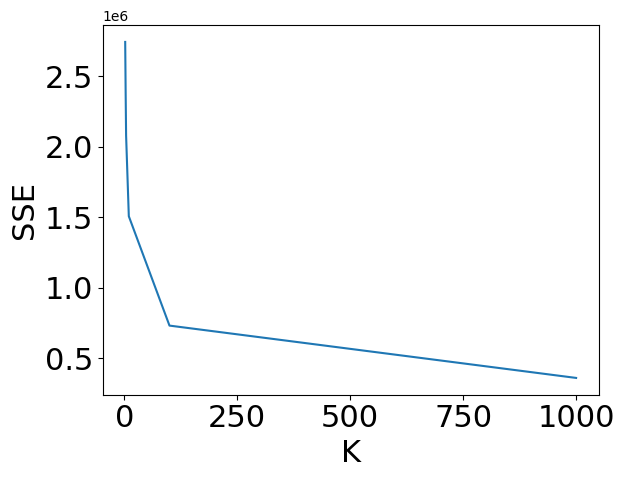

In [9]:
sse_list = [dict_kmeans[f'{k}_sse'] for k in k_grid]
plt.plot(k_grid,sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

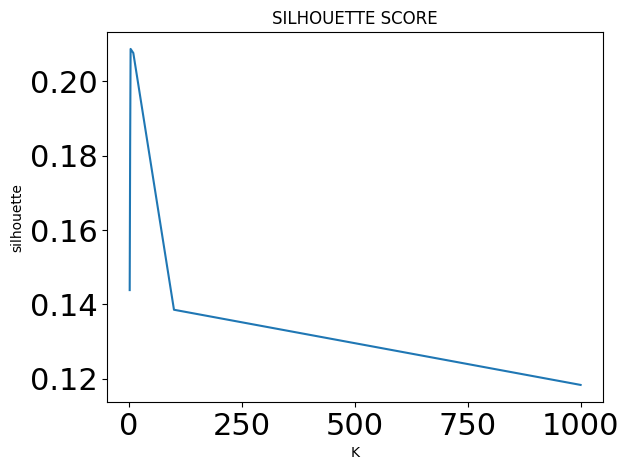

In [10]:
silhouette_list = [dict_kmeans[f'{k}_silhouette_score'] for k in k_grid]
plt.plot(k_grid, silhouette_list)
plt.ylabel('silhouette')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('SILHOUETTE SCORE')
#plt.axvline(6)
plt.show()

In [11]:
#RETRAIN BEST K-MEANS
best_k = 2
best_kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=100)
best_kmeans.fit(df_numeric)

KMeans(max_iter=100, n_clusters=2, n_init=10)

In [12]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))

# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(best_kmeans.labels_ == k))

print('cluster occurrencies:', occ_list)

cluster occurrencies: [152366, 45548]


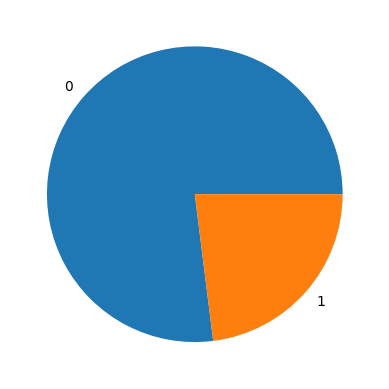

In [13]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

In [14]:
if 'labels' in df.columns:
    print('ok')
    del df['labels']
df['labels'] = pd.Series(best_kmeans.labels_,index=df.index)

In [15]:
sns.pairplot(df,hue='labels', palette=sns.color_palette(n_colors=n_clusters))
plt.show()

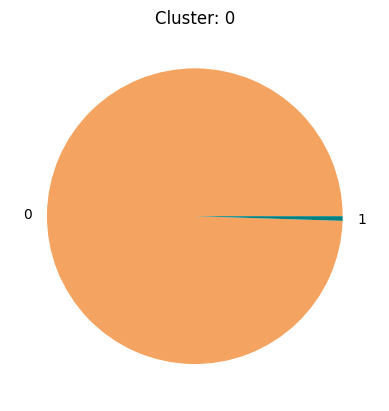

involve_killing
0    151602
1       764
Name: count, dtype: int64


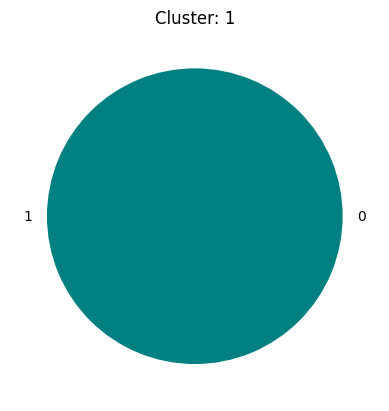

involve_killing
1    45547
0        1
Name: count, dtype: int64


In [15]:
# Calculate number of clusters for final kmeans
n_clusters = len(np.unique(best_kmeans.labels_))
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}


for k in range(n_clusters):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[best_kmeans.labels_ == k].value_counts()
    # Show pie plot
    labels = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)

# X Means 
#### from: https://github.com/annoviko/pyclustering/

In [16]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [21]:
start_centroids = 7
start_clusters = kmeans_plusplus_initializer(df_numeric, start_centroids, random_state=42).initialize()
 
x_means = xmeans(df_numeric, start_clusters, tolerance=1e-6, kmax=20, repeat=10, random_state=42)
x_means.process()
 
# Clustering results:
print(f'Number of clusters found:', np.shape(x_means.get_centers())[0])
print("SSE:", x_means.get_total_wce())

Number of clusters found: 20
SSE: 1392107.078141051


In [20]:
clusters = x_means.get_clusters()

[[111862, 111865, 111891, 111892, 111894, 111895, 111897, 111899, 111901, 111904, 111905, 111906, 111909, 111911, 111922, 111924, 111926, 111928, 111931, 111933, 111935, 111951, 111964, 111974, 111979, 111980, 111996, 112002, 112009, 112018, 112019, 112040, 112054, 112056, 112063, 112073, 112075, 112080, 112089, 112106, 112116, 112122, 112128, 112131, 112137, 112140, 112141, 112144, 112150, 112163, 112174, 112180, 112189, 112196, 112197, 112199, 112206, 112208, 112213, 112214, 112219, 112237, 112246, 112251, 112254, 112265, 112267, 112276, 112281, 112282, 112294, 112297, 112307, 112309, 112310, 112312, 112313, 112334, 112339, 112352, 112353, 112360, 112367, 112383, 112394, 112402, 112412, 112420, 112430, 112438, 112456, 112483, 112488, 112499, 112504, 112505, 112510, 112513, 112518, 112530, 112540, 112548, 112562, 112571, 112579, 112585, 112588, 112591, 112601, 112605, 112608, 112611, 112616, 112619, 112676, 112678, 112697, 112711, 112712, 112715, 112725, 112727, 112729, 112730, 112743

In [19]:
''' 
Since for each cluster is saved the index in list of data
it is needed to convert it in such a way that
we have a list as long as the data, and in each
position it is saved the corresponding label for the
data with that index
'''
for label in range(0, np.shape(clusters)[0]):
  for i in range(0, len(clusters[label])):
      clusters[clusters[label][i]] = label

labels = dict(sorted(clusters.items()))

c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


IndexError: list assignment index out of range

In [ ]:
print('Separation %s' % metrics.davies_bouldin_score(df_numeric, dict_kmeans[f'{k}_labels'])) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(df_numeric, dict_kmeans[f'{k}_labels']))